In [1]:
import os
os.chdir("../")
%pwd

'/home/megh/AI/Projects/Grapevine_Leaf_Classification'

In [2]:
%pwd

'/home/megh/AI/Projects/Grapevine_Leaf_Classification'

In [3]:
import tensorflow as tf

2023-09-15 22:46:44.182193: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 22:46:45.161992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
#model = tf.keras.models.load_model("artifacts/training/model.h5")

In [5]:
from tensorflow.keras.preprocessing import image 


In [6]:
import numpy as np

In [7]:
#imagename = '/home/megh/AI/Projects/Grapevine_Leaf_Classification/test2.png'

In [8]:
#test_image = image.load_img(imagename, target_size = (224,224))
#test_image = image.img_to_array(test_image)
#test_image = np.expand_dims(test_image, axis = 0)
#result = np.argmax(model.predict(test_image), axis=1)

In [10]:
class_names = ['Ak', 'Ala_idris', 'Buzgulu', 'Dimnit,Nazil']
print(f"image belongs to the family {class_names[result[0]]}")

image belongs to the family Ak


In [11]:
result[0]

0

In [12]:
print(result)

[0]


In [10]:
from dataclasses import dataclass
from pathlib import Path   

@dataclass(frozen=True)
class EvaluationConfig:
    path_of_model: Path
    training_data: Path
    all_params: dict
    params_image_size: list
    params_batch_size: int


In [11]:
from CNNClassifier.constants import *
from CNNClassifier.utils.common import read_yaml, create_directories, save_json   

In [12]:
class ConfigurationManager:
    def __init__(self,
                 config_file_path= CONFIG_FILE_PATH,
                 params_file_path= PARAMS_FILE_PATH):

                 self.config = read_yaml(config_file_path)
                 self.params = read_yaml(params_file_path)

                 create_directories([self.config.artifacts_root])


    def get_validation_config(self)-> EvaluationConfig :
            eval_config = EvaluationConfig(
                    
                    path_of_model="artifacts/training/model.h5",
                    training_data = "artifacts/data_ingestion/Grapevine_Leaves_Image_Dataset",
                    all_params= self.params,
                    params_image_size= self.params.IMAGE_SIZE,
                    params_batch_size = self.params.BATCH_SIZE
                                    )
            return eval_config

In [13]:
from urllib.parse import urlparse
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
class Evaluation:
    def __init__(self, config: EvaluationConfig):
        self.config = config
        self.test_labels = []
        self.labels = ['Ak', 'Ala_idris', 'Buzgulu', 'Dimnit','Nazil']


    
    def _valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.30
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )




        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

        number_of_examples = len(self.valid_generator.filenames)
        number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 16)) 


        for i in range(0,int(number_of_generator_calls)):
            self.test_labels.extend(np.array(self.valid_generator[i][1]))


    @staticmethod
    def load_model(path: Path) -> tf.keras.Model:
        return tf.keras.models.load_model(path)
    
    

    def evaluation(self):
        self.model = self.load_model(self.config.path_of_model)
        self._valid_generator()
        self.score = self.model.evaluate(self.valid_generator)
        predicted = self.model.predict(self.valid_generator)

        self.predicted = tf.concat(predicted, axis=0)
        self.predicted = tf.argmax(predicted, axis=1)

        #self.test_labels = tf.concat(self.test_labels, axis=0)
        #self.actual = tf.argmax(self.test_labels, axis=1)

    
    def save_score(self):
        scores = {"loss": self.score[0], "accuracy": self.score[1]}
        save_json(path=Path("scores.json"), data=scores)

    def plot_cm(self):
        self.actual = tf.argmax(self.test_labels, axis=1)
        cm = tf.math.confusion_matrix(self.actual, self.predicted)
        ax = sns.heatmap(cm, annot=True, fmt='g')
        sns.set(rc={'figure.figsize':(12, 12)})
        sns.set(font_scale=1.4)
        ax.set_title('Confusion matrix of action recognition for ' + 'validation')
        ax.set_xlabel('Predicted Action')
        ax.set_ylabel('Actual Action')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        ax.xaxis.set_ticklabels(self.labels)
        ax.yaxis.set_ticklabels(self.labels)

    def metrics(self):
        self.actual = tf.argmax(self.test_labels, axis=1)

        cm = tf.math.confusion_matrix(self.actual, self.predicted)
        tp = np.diag(cm) # Diagonal represents true positives
        precision = dict()
        recall = dict()
        for i in range(len(self.labels)):
          col = cm[:, i]
          fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
      
          row = cm[i, :]
          fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
      
          precision[self.labels[i]] = tp[i] / (tp[i] + fp) # Precision 
      
          recall[self.labels[i]] = tp[i] / (tp[i] + fn) # Recall
      
        return precision, recall



    

In [40]:
config = ConfigurationManager()
val_config = config.get_validation_config()
evaluation = Evaluation(val_config)
evaluation.evaluation()

[2023-09-15 23:04:34,784: INFO: common: yaml fileconfig/config.yamlloaded Successfully]
[2023-09-15 23:04:34,786: INFO: common: yaml fileparams.yamlloaded Successfully]
[2023-09-15 23:04:34,787: INFO: common: created directory at:artifacts]
Found 150 images belonging to 5 classes.
10/10 [==============================] - 1s 81ms/step


In [41]:
evaluation.metrics()

({'Ak': 0.896551724137931,
  'Ala_idris': 0.9130434782608695,
  'Buzgulu': 0.725,
  'Dimnit': 0.9629629629629629,
  'Nazil': 0.9032258064516129},
 {'Ak': 0.8666666666666667,
  'Ala_idris': 0.7,
  'Buzgulu': 0.9666666666666667,
  'Dimnit': 0.8666666666666667,
  'Nazil': 0.9333333333333333})

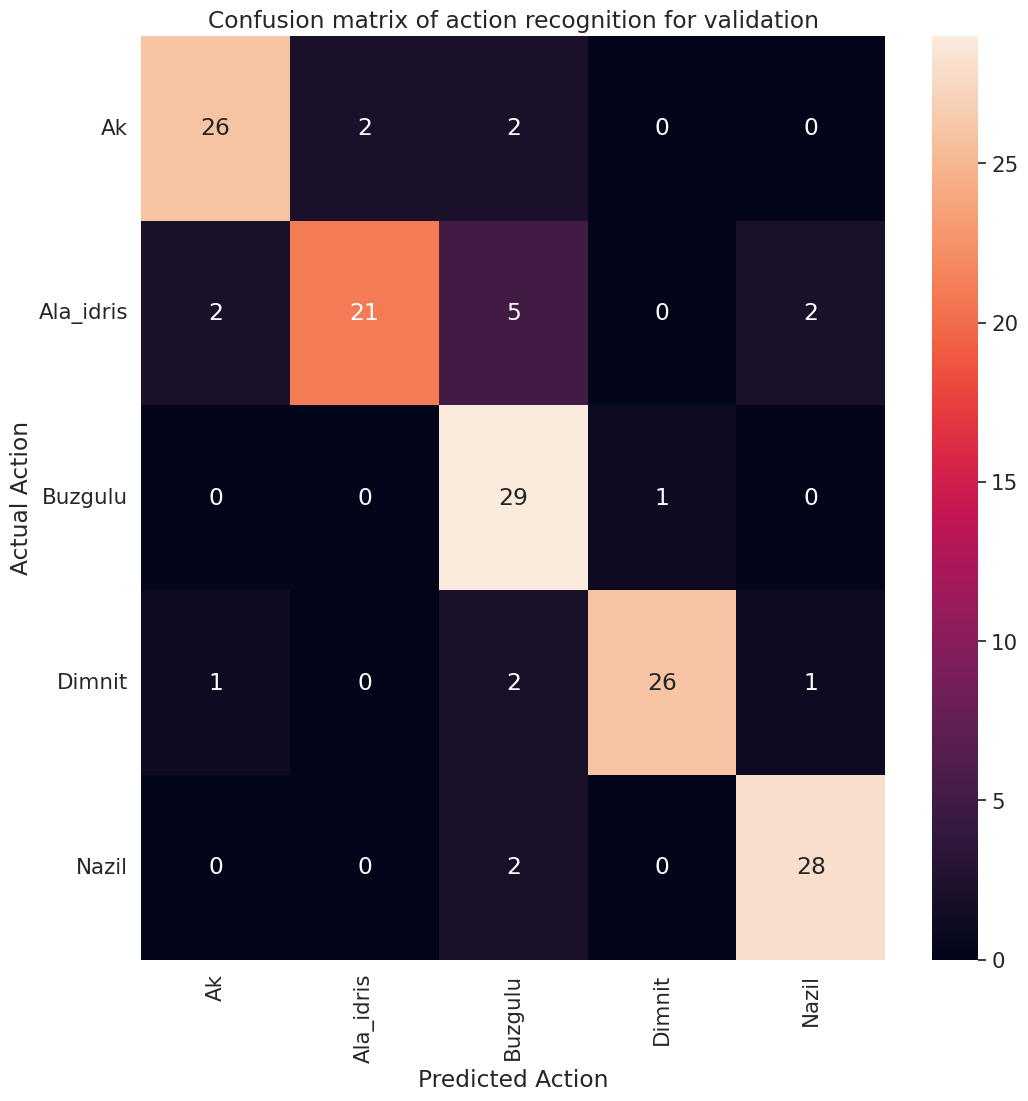

In [35]:
evaluation.plot_cm()

In [24]:
evaluation.plot_cm()


InvalidArgumentError: {{function_node __wrapped__ArgMax_device_/job:localhost/replica:0/task:0/device:GPU:0}} Expected dimension in the range [-1, 1), but got 1 [Op:ArgMax] name: 

In [29]:
test = evaluation.test_labels
test_1 = tf.argmax(test,axis =1)
test_1

<tf.Tensor: shape=(150,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])>

In [28]:
tf.argmax( test_1, axis=1)

InvalidArgumentError: {{function_node __wrapped__ArgMax_device_/job:localhost/replica:0/task:0/device:GPU:0}} Expected dimension in the range [-1, 1), but got 1 [Op:ArgMax] name: 

In [36]:
evaluation.predicted


<tf.Tensor: shape=(150,), dtype=int64, numpy=
array([2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 4, 1, 1, 1, 0, 2, 2, 4, 2, 1, 0,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
       3, 3, 3, 2, 3, 3, 3, 0, 3, 3, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])>

In [18]:
test_batches = ImageDataGenerator().flow_from_directory(.., batch_size=n)
number_of_examples = len(test_batches.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * n)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_batches[i][1]))

SyntaxError: invalid syntax (4167314880.py, line 1)

In [21]:
try:
    config = ConfigurationManager()
    val_config = config.get_validation_config()
    evaluation = Evaluation(val_config)
    evaluation.evaluation()
    evaluation.save_score()

except Exception as e:
   raise e

[2023-09-15 22:23:29,125: INFO: common: yaml fileconfig/config.yamlloaded Successfully]
[2023-09-15 22:23:29,128: INFO: common: yaml fileparams.yamlloaded Successfully]
[2023-09-15 22:23:29,128: INFO: common: created directory at:artifacts]
Found 150 images belonging to 5 classes.


ValueError: Asked to retrieve element 10, but the Sequence has length 10